# Using Convolutional Neural Networks to do image transformations (circles to squares, in this case)

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 4, Homework (this is discussed in session 5)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- train a network to turn circles into squares inside an image

The networks are 2D convolutional networks, with the same input and output dimensions.


### Imports: numpy and matplotlib and keras

In [1]:
# keras: Sequential is the neural-network class, Dense is
# the standard network layer
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, UpSampling2D
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

### Functions

In [34]:
# visualization routines:
# slightly changed for this notebook
# to display both test in / test target and test prediction

def visualize_CNN_training(network,
                               image_generator, resolution,
                    steps=100, batchsize=10,
                              visualize_nsteps=1, plot_img_pixels=3,
                          plot_img_cols=10,
                          plot_img_rows=5,
                          show_intermediate_layers=True,
                          num_tests=1):
    """
    Visualize the training of a (2D) convolutional neural network autoencoder.
    
    network is the network that you have defined using keras.
    
    'resolution' (called M below) is the image resolution in pixels
    
    image_generator is the name of a function that
    is called like
        image_generator(batchsize,x,y)
    and which has to return an array of shape
        [batchsize,M,M]
    that contains randomly generated MxM images (e.g. randomly
    placed circles or whatever you want to consider). The
    MxM arrays x and y are already filled with coordinates between -1 and 1.
    
    An example that returns images of randomly placed circles:
    
    def my_generator(batchsize,x,y):
        R=np.random.uniform(size=batchsize)
        x0=np.random.uniform(size=batchsize,low=-1,high=1)
        y0=np.random.uniform(size=batchsize,low=-1,high=1)
        return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

   
    steps is the number of training steps
    
    batchsize is the number of samples per training step
            
    visualize_n_steps>1 means skip some steps before
    visualizing again (can speed up things)
    
    show_intermediate_layers==True means show the intermediate activations.
    Otherwise show the weights!
    
    These are always shown in the upper left corner, as a tiled image,
    whose properties are determined by:
        plot_img_pixels: the resolution for each of the image tiles
        plot_img_cols  : the number of columns of images
        plot_img_rows  : the number of rows of images
    Images (activations or weights) that are larger will be cut off.
    If there are more images than fit, the rest will be left out.
    The lowest layer starts in the bottom left. For activations, for
    each layer one runs through all the channels, and then the images
    for the next layer will start. Likewise for weights.
    """
    global y_test, y_test_out, y_test_target
    
    M=resolution
        
    vals=np.linspace(-1,1,M)
    x,y=np.meshgrid(vals,vals)
    
    y_test=np.zeros([num_tests,M,M,1])
    y_test_target=np.zeros([num_tests,M,M,1])
    y_test[:,:,:,0],y_test_target[:,:,:,0]=image_generator(num_tests,x,y)
    
    y_in=np.zeros([batchsize,M,M,1])
    y_target=np.zeros([batchsize,M,M,1])

    costs=np.zeros(steps)
    extractor=get_layer_activation_extractor(network)
    
    for j in range(steps):
        # produce samples:
        y_in[:,:,:,0],y_target[:,:,:,0]=image_generator(batchsize,x,y)
        
        # do one training step on this batch of samples:
        costs[j]=network.train_on_batch(y_in,y_target)
        
        # now visualize the updated network:
        if j%visualize_nsteps==0:
            clear_output(wait=True) # for animation
            if j>10:
                cost_max=np.average(costs[0:j])*1.5
            else:
                cost_max=costs[0]
            
            # nice layout (needs matplotlib v3)
            fig=plt.figure(constrained_layout=True,figsize=(8,4))
            gs=fig.add_gridspec(ncols=8,nrows=4)
            filter_plot=fig.add_subplot(gs[0:3,0:4])
            cost_plot=fig.add_subplot(gs[3,0:4])
            test_in_plot=fig.add_subplot(gs[0:2,4:6])
            test_target_plot=fig.add_subplot(gs[0:2,6:8])
            test_out_plot=fig.add_subplot(gs[2:,6:8])

            cost_plot.plot(costs)
            cost_plot.set_ylim([0,cost_max])
            
            # test the network on a fixed test image!
            y_test_out=network.predict_on_batch(y_test)
            test_in_plot.imshow(y_test[0,:,:,0],origin='lower')
            test_out_plot.imshow(y_test_out[0,:,:,0],origin='lower')
            test_target_plot.imshow(y_test_target[0,:,:,0],origin='lower')
            test_in_plot.axis('off')
            test_out_plot.axis('off')
            test_target_plot.axis('off')
            
            if show_intermediate_layers:
                features=extractor(y_test)
                n1=0; n2=0
                max_n1=plot_img_rows
                max_n2=plot_img_cols
                pix=plot_img_pixels
                img=np.full([(pix+1)*max_n1,(pix+1)*max_n2],1.0)
                for feature in features:
                    for m in range(feature.shape[-1]):
                        w=feature[0,:,:,m]
                        ws=np.shape(w)
                        if n1<max_n1 and n2<max_n2:
                            W=np.zeros([pix,pix])
                            if ws[0]<pix:
                                W[0:ws[0],0:ws[0]]=w[:,:]
                            else:
                                W[:,:]=w[0:pix,0:pix]                            
                            img[n1*(pix+1):(n1+1)*(pix+1)-1,n2*(pix+1):(n2+1)*(pix+1)-1]=W
                            n2+=1
                            if n2>=max_n2:
                                n2=0
                                n1+=1                
            else: # rather, we want the weights! (filters)
                n1=0; n2=0
                max_n1=plot_img_rows
                max_n2=plot_img_cols
                pix=plot_img_pixels
                img=np.zeros([(pix+1)*max_n1,(pix+1)*max_n2])
                for ly in network.layers:
                    w=ly.get_weights()
                    if w!=[]:
                        w=w[0]
                        ws=np.shape(w)
                        for k1 in range(ws[2]):
                            for k2 in range(ws[3]):
                                if n1<max_n1 and n2<max_n2:
                                    W=np.zeros([pix,pix])
                                    if ws[0]<pix:
                                        W[0:ws[0],0:ws[0]]=w[:,:,k1,k2]
                                    else:
                                        W[:,:]=w[0:pix,0:pix,k1,k2]                            
                                    img[n1*(pix+1):(n1+1)*(pix+1)-1,n2*(pix+1):(n2+1)*(pix+1)-1]=W
                                    n2+=1
                                    if n2>=max_n2:
                                        n2=0
                                        n1+=1
            filter_plot.imshow(img,origin='lower')
            filter_plot.axis('off')
            plt.show()
    print("Final cost value (averaged over last 50 batches): ", np.average(costs[-50:]))


def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    return(Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    layer_features = extractor(y_in)
    return(layer_features)


## Turning randomly placed circles into squares


In [18]:
def my_generator(batchsize,x,y):
    """
    Place some circles randomly, then place (for the
    target image) squares at the same positions, with
    the same size
    """
    global num_circles

    M=np.shape(x)[0]
    theCircles=np.zeros([batchsize,M,M])
    theSquares=np.zeros([batchsize,M,M])
    
    for j in range(num_circles):
        R=np.random.uniform(size=batchsize)*0.5
        x0=np.random.uniform(size=batchsize,low=-1,high=1)
        y0=np.random.uniform(size=batchsize,low=-1,high=1)
        theCircles+=1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2)
        theSquares+=1.0*(np.abs(x[None,:,:]-x0[:,None,None])< R[:,None,None])*(np.abs(y[None,:,:]-y0[:,None,None])< R[:,None,None])
    return theCircles,theSquares

num_circles=5

Net=Sequential()
num_channels=20
kernel_size=5
num_layers=4

for j in range(num_layers):
    if j==0:
        the_input_shape=(None,None,1)
    else:
        the_input_shape=(None,None,num_channels)
    Net.add(Conv2D(num_channels,kernel_size,input_shape=the_input_shape,
               activation="relu",padding='same'))
Net.add(Conv2D(1,kernel_size,activation="linear",padding='same'))
Net.compile(loss='mean_squared_error',
              optimizer='adam')

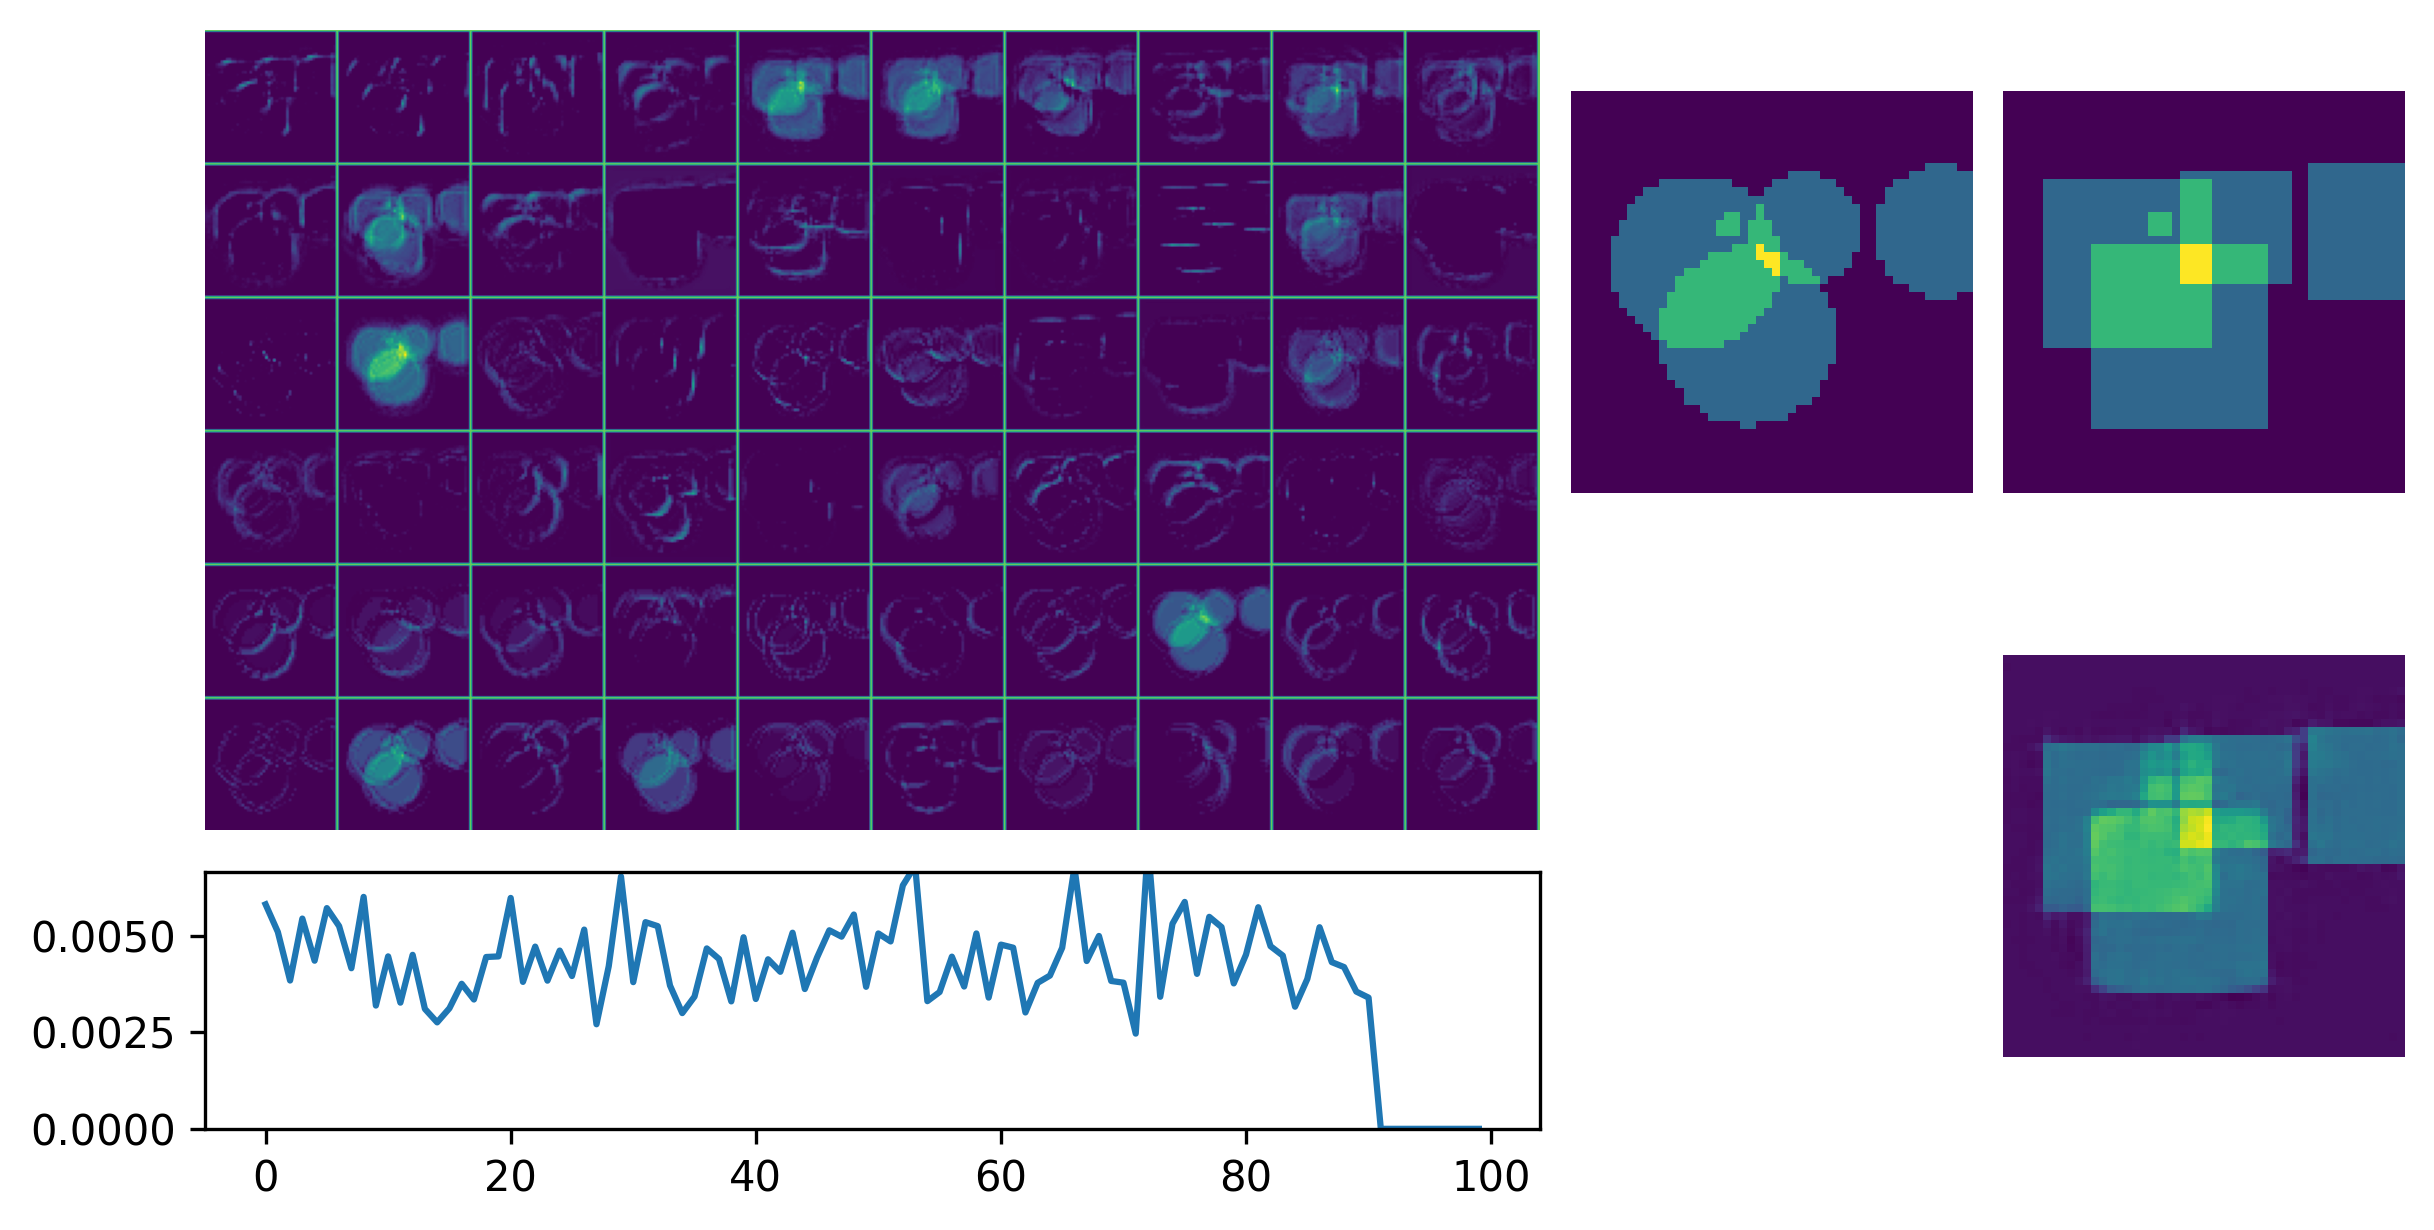

Final cost value (averaged over last 50 batches):  0.004558101058937609


In [40]:
# run this for at least 300 steps (batchsize 10) to
# get decent results
visualize_CNN_training(Net, my_generator, 50,
                    steps=100, batchsize=10,
                              visualize_nsteps=10,
                      plot_img_pixels=50, 
                       plot_img_rows=6, plot_img_cols=10)

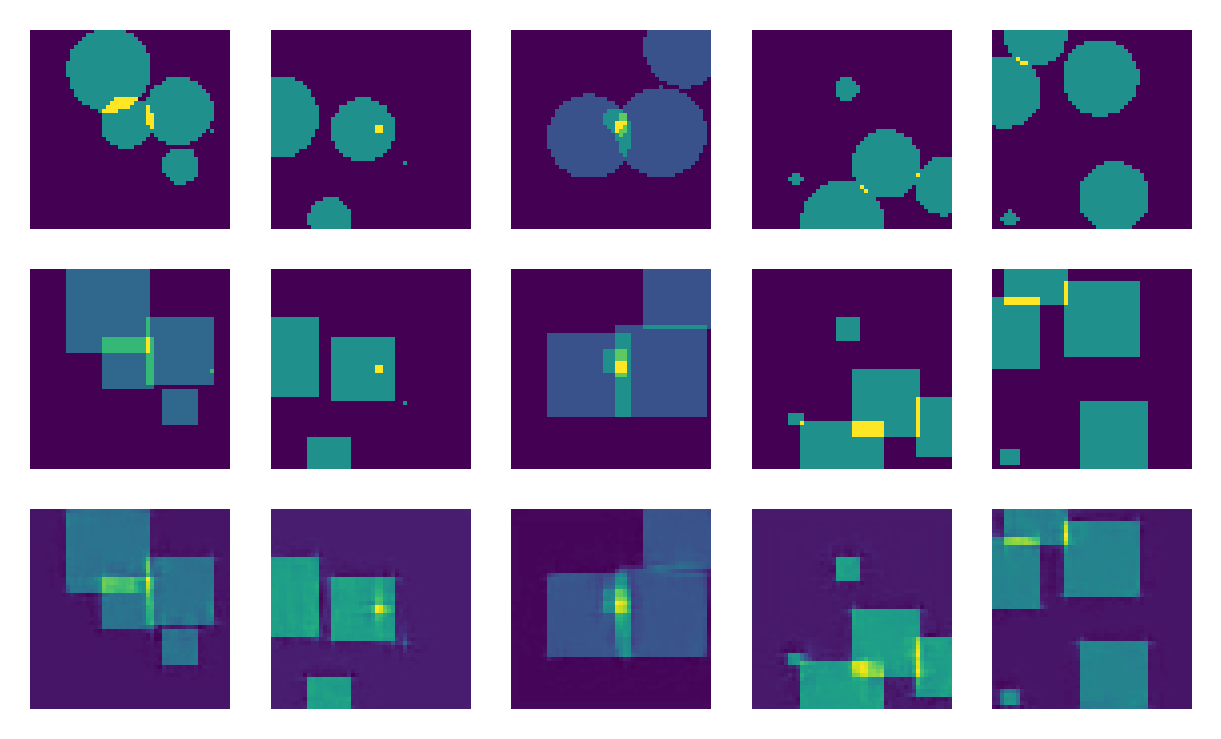

In [39]:
# run the cell before, but with num_tests=5 option
# then run this cell!
#
# show the typical test images (these are available
# in the global variable y_test after calling the visualization routine)
fig,ax=plt.subplots(ncols=5,nrows=3,figsize=(5,3))
for j in range(5):
    ax[0,j].imshow(y_test[j,:,:,0],origin='lower') # the last training images...
    ax[0,j].axis('off')
    ax[1,j].imshow(y_test_target[j,:,:,0],origin='lower') # the last training images...
    ax[1,j].axis('off')
    ax[2,j].imshow(y_test_out[j,:,:,0],origin='lower') # the last training images...
    ax[2,j].axis('off')
plt.show()